In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import keras
import datetime as dt
from scipy.stats import boxcox
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
import keras_tuner
from tensorflow.keras import layers

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-05-05 10:57:07.782007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Reading the data

coupling = pd.read_csv('/Users/natalia/Documents/Doctorado/ZLi_Team_Papers/Spring2023/acoplamiento_10min.csv', index_col = 0, parse_dates = True)
coupling = coupling.resample('1min').interpolate(method = 'nearest')

#Reading the W data
omega = pd.read_csv('Omega_60varanaruc.csv', index_col = 0, parse_dates = True)
omega_850 = omega['850.0'].resample('1min').interpolate(method = 'linear')

df = pd.read_csv('Datos_primeros_intentos_1min.csv', index_col = 0, parse_dates = True)
#df = pd.read_csv('Datos_primeros_intentos.csv', index_col = 0, parse_dates = True)
df = pd.concat([df, coupling['Coupling_Flag'], omega_850.reindex(df.index)], axis = 1)
df[df['lwp'] == 0.0] = np.NaN
df = df[['CAPE','CPC','lwp','Coupling_Flag','850.0','irt']].dropna()

df.shape

(38266, 6)

In [3]:
df.dropna()

,CAPE,CPC,lwp,Coupling_Flag,850.0,irt
2004-01-07 12:43:00,883.486582,9002.200195,0.020105,-1.0,4.914970,214.921143
2004-01-07 12:44:00,871.099362,9008.200195,0.021836,-1.0,4.915411,218.538127
2004-01-07 12:45:00,861.844622,9030.400391,0.027090,-1.0,4.915851,219.071671
2004-01-07 12:46:00,871.677418,9045.200195,0.029888,-1.0,4.916292,221.305216
2004-01-07 12:47:00,864.320673,9023.000000,0.032845,-1.0,4.916732,229.243230
...,...,...,...,...,...,...
2011-07-30 17:38:00,743.593212,2426.399902,0.444301,-1.0,7.213852,286.273254
2011-07-30 17:44:00,631.176197,2283.800049,0.328820,-1.0,7.249704,285.873627
2011-07-30 17:45:00,740.759860,2269.699951,0.186447,-1.0,7.255679,285.715841
2011-07-30 17:46:00,826.375833,2253.399902,0.227679,-1.0,7.261655,285.667948


In [4]:
# helper function for random split
def random_split(data, label, split=0.2, seed=0):
    """
    Help splitting data randomly for training and testing.
    """
    np.random.seed(seed)
    da_indx = np.random.permutation(data.shape[0])
    data  = data[da_indx.astype(int)]
    label = label[da_indx.astype(int)]
    init_range = int(data.shape[0] * (1 - 0.2))
    return (
        data[:init_range], label[:init_range],
        data[init_range:], label[init_range:]
        )

In [5]:
train_X, train_Y, test_X, test_Y = random_split(df[['CAPE','CPC','lwp','Coupling_Flag','850.0']].values, df['irt'].values, split=0.2, seed=85)

In [6]:
# Try different lambda values to find the optimal one and transform the data
transformed_train_X = np.zeros(train_X.shape)*np.NaN
lambda_values_train_X = []
for i in range(train_X.shape[1]-2):
    # Try different lambda values to find the optimal one
    best_lambda = None
    best_skewness = float('inf')
    for lmbda in np.arange(-2, 2.1, 0.1):  # Range of lambda values to try
        # Apply Box-Cox transformation
        transformed_data_temp = boxcox(train_X[:,i], lmbda=lmbda)
        
        # Calculate skewness after transformation
        transformed_skewness = skew(transformed_data_temp)
        
        # Update best lambda if current skewness is lower
        if abs(transformed_skewness) < best_skewness:
            best_lambda = lmbda
            best_skewness = abs(transformed_skewness)
    lambda_values_train_X.append(best_lambda)
    transformed_train_X[:,i] = boxcox(train_X[:,i], lmbda = best_lambda)
transformed_train_X[:,-2] = train_X[:,-2]
transformed_train_X[:,-1] = train_X[:,-1]

/Users/natalia/opt/anaconda3/envs/Keras_new/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1070: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


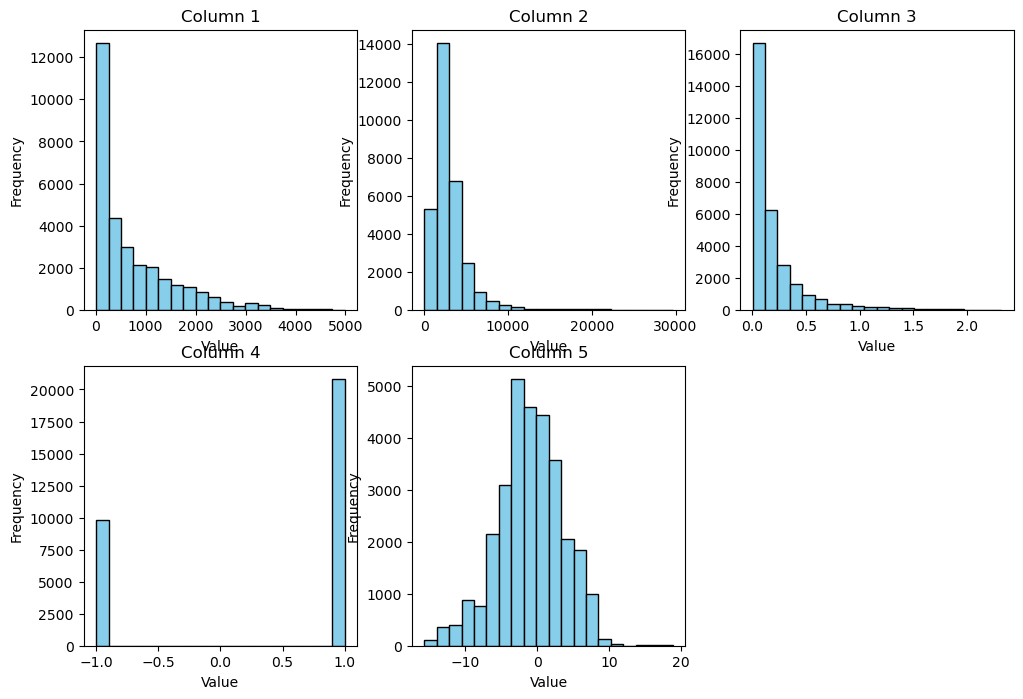

In [7]:
num_cols = transformed_train_X.shape[1]
fig, axs = plt.subplots(2, num_cols-2, figsize=(12, 8))

c = 0
for i in range(2):
    for j in range(3):
        if i * 3 + j < 5:
            axs[i,j].hist(train_X[:, c], bins=20, color='skyblue', edgecolor='black')
            axs[i,j].set_title(f'Column {c+1}')
            axs[i,j].set_xlabel('Value')
            axs[i,j].set_ylabel('Frequency')
            c = c + 1
# Remove the last subplot
fig.delaxes(axs[1, 2])

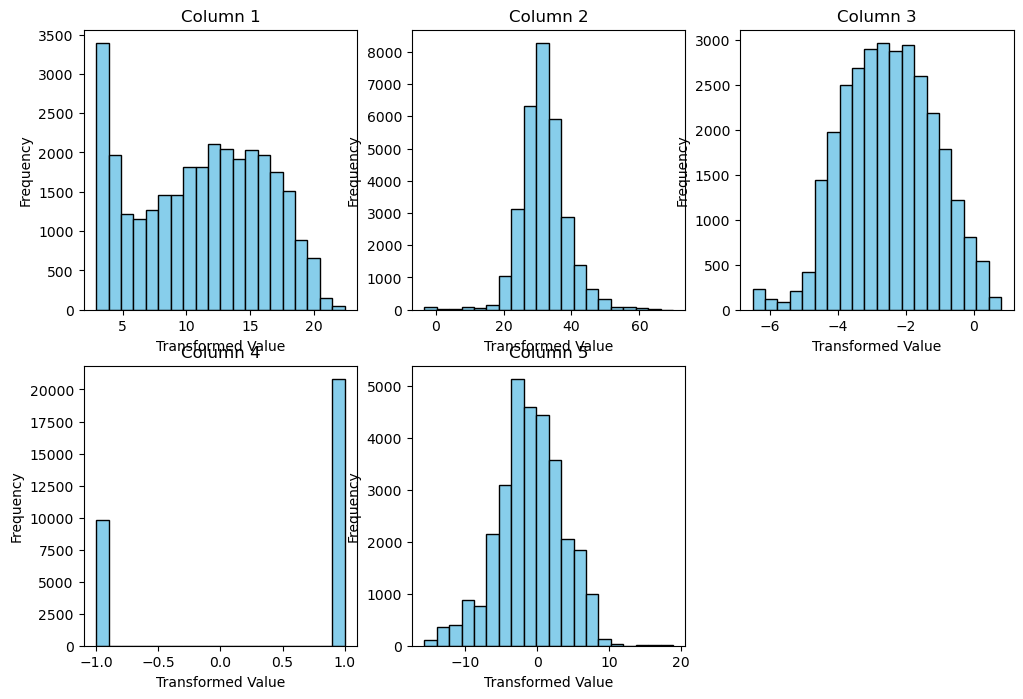

In [8]:
num_cols = transformed_train_X.shape[1]
fig, axs = plt.subplots(2, num_cols-2, figsize=(12, 8))

c = 0
for i in range(2):
    for j in range(3):
        if i * 3 + j < 5:
            axs[i,j].hist(transformed_train_X[:, c], bins=20, color='skyblue', edgecolor='black')
            axs[i,j].set_title(f'Column {c+1}')
            axs[i,j].set_xlabel('Transformed Value')
            axs[i,j].set_ylabel('Frequency')
            c = c + 1
# Remove the last subplot
fig.delaxes(axs[1, 2])

In [9]:
# Try different lambda values to find the optimal one and transform the data
transformed_train_Y = np.zeros(train_Y.shape[0])*np.NaN
lambda_values_train_Y = []
best_lambda = None
best_skewness = float('inf')
for lmbda in np.arange(5, 18.1, 0.1):  # Range of lambda values to try
    # Apply Box-Cox transformation
    transformed_data_temp = boxcox(train_Y, lmbda=lmbda)
    
    # Calculate skewness after transformation
    transformed_skewness = skew(transformed_data_temp)
    
    # Update best lambda if current skewness is lower
    if abs(transformed_skewness) < best_skewness:
        best_lambda = lmbda
        best_skewness = abs(transformed_skewness)
lambda_values_train_Y.append(best_lambda)
transformed_train_Y = boxcox(train_Y, lmbda = best_lambda)

In [10]:
transformed_train_Y = transformed_train_Y.reshape(-1,1)
transformed_train_Y

array([[1.01216661e+43],
       [9.13852997e+42],
       [1.09016481e+43],
       ...,
       [3.67341364e+42],
       [9.83404920e+42],
       [8.56227669e+42]])

In [11]:
transformed_train_X

array([[19.18755425, 29.90997345, -3.60435739, -1.        , -2.18361315],
       [12.26140606, 27.94460048, -4.05310281,  1.        ,  0.57977606],
       [14.21893072, 25.60452339,  0.55274796,  1.        ,  3.17745638],
       ...,
       [ 9.28656255, 23.28793081, -3.16875027,  1.        , -2.35215979],
       [11.11902415, 31.28778503, -1.33068262, -1.        , -1.85781832],
       [ 5.49485596, 36.36607478, -0.5305201 ,  1.        , -4.18759334]])

Text(0, 0.5, 'Frequency')

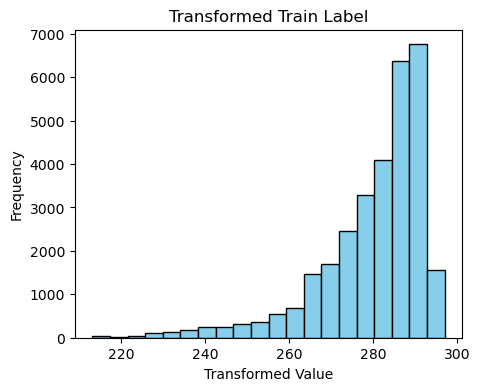

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(5, 4))

axs.hist(train_Y, bins=20, color='skyblue', edgecolor='black')
axs.set_title('Transformed Train Label')
axs.set_xlabel('Transformed Value')
axs.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

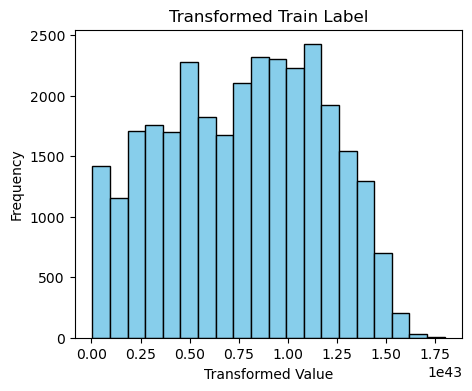

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(5, 4))

axs.hist(transformed_train_Y, bins=20, color='skyblue', edgecolor='black')
axs.set_title('Transformed Train Label')
axs.set_xlabel('Transformed Value')
axs.set_ylabel('Frequency')

In [14]:
# Apply Min-Max scaling to transform the data to the range [-1, 1]
scaler_train_X = MinMaxScaler(feature_range=(-1, 1))
scaler_train_Y = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler on the training data and transform both training and testing data
normalized_X_train = scaler_train_X.fit_transform(transformed_train_X)
normalized_Y_train = scaler_train_Y.fit_transform(transformed_train_Y)

In [15]:
def build_model0(hp):
    # start building model
    keras.utils.set_random_seed(85) # BEST FOR NOW
    model = keras.Sequential()
    # input layer stays the same as before
    model.add(keras.Input(shape=(4,), name="input_layer"))
    # instead of choosing the number of nodes, we add an hp object
    hp_units_1 = hp.Int('units_1', min_value=2, max_value=12, step=1)
    hp_units_2 = hp.Int('units_2', min_value=2, max_value=12, step=1)
    model.add(
        keras.layers.Dense(
            units=hp_units_1,
            activation=keras.activations.relu
            )
        )
    model.add(
        keras.layers.Dense(
            units=hp_units_2,
            activation=keras.activations.relu
            )
        )
    model.add(keras.layers.Dense(units=1)) #1 output
    # likewise, we will search for the learning rate
    learning_rate = hp.Float(
        "lr", min_value=1e-4, max_value=1e-2, sampling="log"
        )
    model.compile(
        keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse'
        )
    return model

# Define the model-building function
def build_model(hp):
    keras.utils.set_random_seed(85) # BEST FOR NOW
    model = keras.Sequential()
    batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=32)
    model.add(layers.Input(shape=(5,), name="input_layer"))  # Input layer
    for i in range(hp.Int('num_layers', 1, 5)):  # Search for the number of dense layers
        model.add(layers.Dense(units=hp.Int(f'units_{i}', 2, 16, step=1), activation=keras.activations.relu))  # Search for the number of neurons in each layer
    model.add(layers.Dense(1, activation='linear'))  # Output layer
    learning_rate = hp.Float(
        "lr", min_value=1e-4, max_value=1e-2, sampling="log"
        )
    model.compile(
        keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse'
        )
    return model

In [16]:
keras.utils.set_random_seed(85) # BEST FOR NOW
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=1000,
    seed=85,
    overwrite=True
)

2024-05-05 10:58:20.945447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
batch_size (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(
    normalized_X_train[:round(normalized_X_train.shape[0]*0.8)],
    normalized_Y_train[:round(normalized_X_train.shape[0]*0.8)],
    epochs=25,
    validation_data=(
        normalized_X_train[round(normalized_X_train.shape[0]*0.8):],
        normalized_Y_train[round(normalized_X_train.shape[0]*0.8):])
    )

Trial 1 Complete [00h 00m 21s]
val_loss: 0.15450164675712585

Best val_loss So Far: 0.15450164675712585
Total elapsed time: 00h 00m 21s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
32                |32                |batch_size
2                 |4                 |num_layers
3                 |4                 |units_0
0.00069517        |0.0006237         |lr
15                |2                 |units_1
10                |2                 |units_2
13                |2                 |units_3

Epoch 1/25
766/766 [==============================] - 1s 1ms/step - loss: 0.1816 - val_loss: 0.1324
Epoch 2/25
766/766 [==============================] - 1s 941us/step - loss: 0.1247 - val_loss: 0.1191
Epoch 3/25
766/766 [==============================] - 1s 969us/step - loss: 0.1172 - val_loss: 0.1156
Epoch 4/25
766/766 [==============================] - 1s 1ms/step - loss: 0.1152 - val_loss: 0.1139
Epoch 5/25
766/766 [==============================] - 1s

In [ ]:
# we can now query the tuner object and grab the best models
# here we grab the best two models
models = tuner.get_best_models(num_models=2)
models

In [ ]:
# here is the best model
best_model = models[0]
best_model.summary()

In [ ]:
# here is the second best model
best_model = models[1]
best_model.summary()

In [ ]:
# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=1)
best_learning_rate = best_hps[0].get('lr')
best_batch_size = best_hps[0].get('batch_size')
best_learning_rate

In [ ]:
# Build the model with the best hp.
model = build_model(best_hps[0])

In [ ]:
train_X.shape, train_Y.shape

In [ ]:
# now train!

import keras.backend as K
from keras.layers import Dense, Dropout

# Define custom loss function for RMSE
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Define custom Huber loss function
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = K.abs(error) < delta
    squared_loss = 0.5 * K.square(error)
    linear_loss = delta * (K.abs(error) - 0.5 * delta)
    return K.mean(K.switch(is_small_error, squared_loss, linear_loss))

history = model.fit(
    x=normalized_X_train,
    y=normalized_Y_train,
    epochs=20,
    validation_split=0.1,
    batch_size=128,
    )

In [ ]:
plt.plot(range(0,20), history.history['loss'], c='k', label = 'Train', marker = 'o', ms = 3)
plt.plot(range(0,20), history.history['val_loss'], c='r', label = 'Validation', marker = 'o', ms = 3)
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('MSE')
#plt.grid()
plt.savefig('Val_Train_curves.png', dpi = 250)
plt.show()

In [120]:
transformed_test_X = np.zeros(test_X.shape)*np.NaN
transformed_test_X[:,0] = boxcox(test_X[:,0], lmbda = lambda_values_train_X[0])
transformed_test_X[:,1] = boxcox(test_X[:,1], lmbda = lambda_values_train_X[1])
transformed_test_X[:,2] = boxcox(test_X[:,2], lmbda = lambda_values_train_X[2])
transformed_test_X[:,-1] = test_X[:,-1]
transformed_test_X[:,-2] = test_X[:,-2]

transformed_test_Y = np.zeros(test_Y.shape[0])*np.NaN
transformed_test_Y = boxcox(test_Y, lmbda = lambda_values_train_Y[0])
transformed_test_Y = transformed_test_Y.reshape(-1,1)

In [121]:
# Fit the scaler on the training data and transform both training and testing data
normalized_X_test = scaler_train_X.transform(transformed_test_X)
normalized_Y_test = scaler_train_Y.transform(transformed_test_Y)

In [122]:
# to predict, use predict call
predictions = model.predict(
    x=normalized_X_test,
)

240/240 [==============================] - 0s 588us/step


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


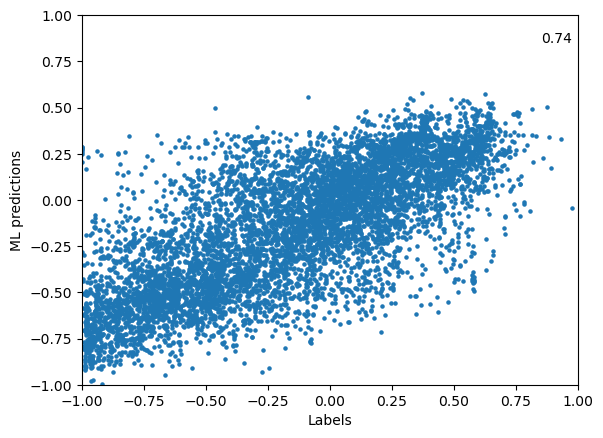

In [123]:
plt.scatter(normalized_Y_test, predictions, s = 5)
#plt.colorbar()
plt.xlabel('Labels')
plt.ylabel('ML predictions')
plt.text(0.85, 0.85, '%s'%round(np.corrcoef(normalized_Y_test.T[0], predictions.T[0])[0,1], 2))
plt.ylim(-1,1)
plt.xlim(-1,1)
plt.show()

In [129]:
best_batch_size = best_hps[0].get('batch_size')
best_batch_size

128

In [125]:
#model.save('BestRegresion_IRT2.keras')
#model2 = keras.models.load_model('autoencodersample.keras')